## **Imports, mount drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction')

import os
import joblib
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tabulate import tabulate

# Bokeh Visualization
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column, row
from bokeh.palettes import Category10
from bokeh.models import ColumnDataSource, HoverTool, Legend

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Dropout,
    Input,
    BatchNormalization,
    Bidirectional
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)
from tensorflow.keras.regularizers import L1L2, l2
from tensorflow.keras.metrics import (
    MeanAbsolutePercentageError,
    RootMeanSquaredError,
    MeanAbsoluteError,
    MeanSquaredError
)

# Scikit-learn Metrics
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    root_mean_squared_error
)

# Project-specific Configuration
from config import *

# Enable Bokeh output in notebooks
output_notebook()

Mounted at /content/drive


# **Seed initialization for reproducibility across all libraries**

In [2]:
seed=0
os.environ['PYTHONHASHSEED'] = str(seed)
# For working on GPUs from "TensorFlow Determinism"
os.environ["TF_DETERMINISTIC_OPS"] = str(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# **Loads training, validation, and test datasets along with feature and target scalers.**

In [3]:
def load_datasets(data_path, dataset_name):
    train_data = pd.read_csv(f"{data_path}/{dataset_name}_train.csv", index_col=0)
    val_data = pd.read_csv(f"{data_path}/{dataset_name}_val.csv", index_col=0)
    test_data = pd.read_csv(f"{data_path}/{dataset_name}_test.csv", index_col=0)

    try:
        train_data.index = pd.to_datetime(train_data.index, utc=True),
        val_data.index = pd.to_datetime(val_data.index, utc=True),
        test_data.index = pd.to_datetime(test_data.index, utc=True)
    except:
        pass

    features_scaler = joblib.load(f"{data_path}/{dataset_name}_features_scaler.joblib")
    target_scaler = joblib.load(f"{data_path}/{dataset_name}_target_scaler.joblib")

    return train_data, val_data, test_data, features_scaler, target_scaler

    return train_data, val_data, test_data, features_scaler, target_scaler

# **Load datasets with different preprocessing methods and splits**

In [4]:
# Load minmax_split_first datasets
train_data, val_data, test_data, features_scaler, target_scaler = load_datasets(
    data_path=f"{PROCESSED_DATA_PATH}/minmax_split_first",
    dataset_name="normal_data"
)

# Load minmax_split_last datasets
train_data_last, val_data_last, test_data_last, features_scaler_last, target_scaler_last = load_datasets(
    data_path=f"{PROCESSED_DATA_PATH}/minmax_split_last",
    dataset_name="normal_data"
)

# Load log-transformed minmax_split_first datasets
train_log_data, val_log_data, test_log_data, features_log_scaler, target_log_scaler = load_datasets(
    data_path=f"{PROCESSED_DATA_PATH}/minmax_split_first",
    dataset_name="log_data"
)

# Load log-transformed minmax_split_last datasets
train_log_data_last_last, val_log_data_last_last, test_log_data_last_last, features_log_scaler_last, target_log_scaler_last = load_datasets(
    data_path=f"{PROCESSED_DATA_PATH}/minmax_split_last",
    dataset_name="log_data"
)

In [5]:
# 1.Load custom_split_first datasets
train_data_custom, val_data_custom, test_data_custom, custom_features_scaler, custom_target_scaler = load_datasets(
    data_path=f"{PROCESSED_DATA_PATH}/custom_split_first",
    dataset_name="normal_data"
)

# 2.Load custom_split_last datasets
train_data_custom_last, val_data_custom_last, test_data_custom_last, custom_features_scaler_last, custom_target_scaler_last = load_datasets(
    data_path=f"{PROCESSED_DATA_PATH}/custom_split_last",
    dataset_name="normal_data_last"
)

# 3.Load custom_split_first_log datasets
train_log_data_custom, val_log_data_custom, test_log_data_custom, custom_features_log_scaler, custom_target_log_scaler = load_datasets(
    data_path=f"{PROCESSED_DATA_PATH}/custom_split_first",
    dataset_name="log_data"
)

# 4.Load custom_split_last log datasets
train_log_data_custom_last, val_log_data_custom_last, test_log_data_custom_last, custom_features_log_scaler_last, custom_target_log_scaler = load_datasets(
    data_path=f"{PROCESSED_DATA_PATH}/custom_split_last",
    dataset_name="log_data_last"
)

# **Creates sequences of features and targets for time series modeling.**

In [6]:
def create_sequences(data, feature_cols, target_cols, sequence_length, save_path=None, save_name=None):
    features = data[feature_cols].values
    targets = data[target_cols].values

    n_samples = len(data) - sequence_length
    n_features = len(feature_cols)
    n_targets = len(target_cols)

    X = np.zeros((n_samples, sequence_length, n_features))
    y = np.zeros((n_samples, n_targets))
    dates = np.empty(n_samples, dtype=object)

    for i in range(n_samples):
        X[i] = features[i:i+sequence_length]
        y[i] = targets[i+sequence_length-1]
        dates[i] = data.index[i+sequence_length]

    if save_path and save_name:
        os.makedirs(save_path, exist_ok=True)
        np.save(f"{save_path}/{save_name}_X.npy", X)
        np.save(f"{save_path}/{save_name}_y.npy", y)
        np.save(f"{save_path}/{save_name}_dates.npy", dates)

    return X, y, dates

# **Loads pre-saved sequences of features, targets, and associated dates.**

In [7]:
def load_sequences(path, name):
    X = np.load(f"{path}/{name}_X.npy")
    y = np.load(f"{path}/{name}_y.npy")
    dates = np.load(f"{path}/{name}_dates.npy", allow_pickle=True)

    return X, y, dates

# **Generate input and target sequences for all datasets using a specified sequence length.**
### This section creates sequences for four dataset variations:
### 1. Normal data with "minmax_split_first" strategy
### 2. Normal data with "minmax_split_last" strategy
### 3. Log-transformed data with "minmax_split_first" strategy
### 4. Log-transformed data with "minmax_split_last" strategy
### The create_sequences function is used to transform raw data into sequences suitable for time series modeling.
### Finally, the shapes of all generated datasets are printed to verify the correctness of the data preparation process.

In [9]:
# Define parameters
feature_cols = ['Close']
target_cols = ['Target']
sequence_length = 21

# 1. Create sequences for minmax_split_first normal data
X_train, y_train, train_dates = create_sequences(
    data=train_data,
    feature_cols=feature_cols,
    target_cols=target_cols,
    sequence_length=sequence_length,
)

X_val, y_val, val_dates = create_sequences(
    data=val_data,
    feature_cols=feature_cols,
    target_cols=target_cols,
    sequence_length=sequence_length,
)

X_test, y_test, test_dates = create_sequences(
    data=test_data,
    feature_cols=feature_cols,
    target_cols=target_cols,
    sequence_length=sequence_length,
)

# 2. Create sequences for minmax_split_last normal data
X_train_last, y_train_last, train_dates_last = create_sequences(
    data=train_data_last,
    feature_cols=feature_cols,
    target_cols=target_cols,
    sequence_length=sequence_length,
)

X_val_last, y_val_last, val_dates_last = create_sequences(
    data=val_data_last,
    feature_cols=feature_cols,
    target_cols=target_cols,
    sequence_length=sequence_length,
)

X_test_last, y_test_last, test_dates_last = create_sequences(
    data=test_data_last,
    feature_cols=feature_cols,
    target_cols=target_cols,
    sequence_length=sequence_length,
)

# 3. Create sequences for minmax_split_first log data
X_train_log, y_train_log, train_dates_log = create_sequences(
    data=train_log_data,
    feature_cols=feature_cols,
    target_cols=target_cols,
    sequence_length=sequence_length,
)

X_val_log, y_val_log, val_dates_log = create_sequences(
    data=val_log_data,
    feature_cols=feature_cols,
    target_cols=target_cols,
    sequence_length=sequence_length,
)

X_test_log, y_test_log, test_dates_log = create_sequences(
    data=test_log_data,
    feature_cols=feature_cols,
    target_cols=target_cols,
    sequence_length=sequence_length,
)

# 4. Create sequences for minmax_split_last log data
X_train_log_last, y_train_log_last, train_dates_log_last = create_sequences(
    data=train_log_data_last_last,
    feature_cols=feature_cols,
    target_cols=target_cols,
    sequence_length=sequence_length,
)

X_val_log_last, y_val_log_last, val_dates_log_last = create_sequences(
    data=val_log_data_last_last,
    feature_cols=feature_cols,
    target_cols=target_cols,
    sequence_length=sequence_length,
)

X_test_log_last, y_test_log_last, test_dates_log_last = create_sequences(
    data=test_log_data_last_last,
    feature_cols=feature_cols,
    target_cols=target_cols,
    sequence_length=sequence_length,
)

# Print shapes to verify
print("Normal Data, Split First:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

print("\nNormal Data, Split Last:")
print(f"X_train_last shape: {X_train_last.shape}, y_train_last shape: {y_train_last.shape}")
print(f"X_val_last shape: {X_val_last.shape}, y_val_last shape: {y_val_last.shape}")
print(f"X_test_last shape: {X_test_last.shape}, y_test_last shape: {y_test_last.shape}")

print("\nLog Data, Split First:")
print(f"X_train_log shape: {X_train_log.shape}, y_train_log shape: {y_train_log.shape}")
print(f"X_val_log shape: {X_val_log.shape}, y_val_log shape: {y_val_log.shape}")
print(f"X_test_log shape: {X_test_log.shape}, y_test_log shape: {y_test_log.shape}")

print("\nLog Data, Split Last:")
print(f"X_train_log_last shape: {X_train_log_last.shape}, y_train_log_last shape: {y_train_log_last.shape}")
print(f"X_val_log_last shape: {X_val_log_last.shape}, y_val_log_last shape: {y_val_log_last.shape}")
print(f"X_test_log_last shape: {X_test_log_last.shape}, y_test_log_last shape: {y_test_log_last.shape}")

Normal Data, Split First:
X_train shape: (2191, 21, 1), y_train shape: (2191, 1)
X_val shape: (256, 21, 1), y_val shape: (256, 1)
X_test shape: (256, 21, 1), y_test shape: (256, 1)

Normal Data, Split Last:
X_train_last shape: (2191, 21, 1), y_train_last shape: (2191, 1)
X_val_last shape: (256, 21, 1), y_val_last shape: (256, 1)
X_test_last shape: (256, 21, 1), y_test_last shape: (256, 1)

Log Data, Split First:
X_train_log shape: (2191, 21, 1), y_train_log shape: (2191, 1)
X_val_log shape: (256, 21, 1), y_val_log shape: (256, 1)
X_test_log shape: (256, 21, 1), y_test_log shape: (256, 1)

Log Data, Split Last:
X_train_log_last shape: (2191, 21, 1), y_train_log_last shape: (2191, 1)
X_val_log_last shape: (256, 21, 1), y_val_log_last shape: (256, 1)
X_test_log_last shape: (256, 21, 1), y_test_log_last shape: (256, 1)


# **Generate input and target sequences for all custom datasets using the specified sequence length.**
  ### This section covers four scenarios:
  ### 1. Custom normal data with "custom_split_first" strategy
  ### 2. Custom normal data with "custom_split_last" strategy
  ### 3. Log-transformed custom data with "custom_split_first" strategy
  ### 4. Log-transformed custom data with "custom_split_last" strategy
  ### Each scenario uses the create_sequences function to transform raw data into time series sequences.
  ### The feature and target columns are customized as 'Custom_Normalized' and 'Target', respectively.

In [10]:
feature_cols_custom = ['Custom_Normalized']
target_cols_custom = ['Target']

# 1.Create sequnces for custom custom_split_first normal data
X_train_custom, y_train_custom, train_dates_custom = create_sequences(
    data=train_data_custom,
    feature_cols=feature_cols_custom,
    target_cols=target_cols_custom,
    sequence_length=sequence_length,
)

X_val_custom, y_val_custom, val_dates_custom = create_sequences(
    data=val_data_custom,
    feature_cols=feature_cols_custom,
    target_cols=target_cols_custom,
    sequence_length=sequence_length,
)

X_test_custom, y_test_custom, test_dates_custom = create_sequences(
    data=test_data_custom,
    feature_cols=feature_cols_custom,
    target_cols=target_cols_custom,
    sequence_length=sequence_length,
)

# 2. Create sequences for custom_split_last normal data
X_train_custom_last, y_train_custom_last, train_dates_custom_last = create_sequences(
    data=train_data_custom_last,
    feature_cols=feature_cols_custom,
    target_cols=target_cols_custom,
    sequence_length=sequence_length,
)

X_val_custom_last, y_val_custom_last, val_dates_custom = create_sequences(
    data=val_data_custom_last,
    feature_cols=feature_cols_custom,
    target_cols=target_cols_custom,
    sequence_length=sequence_length,
)

X_test_custom_last, y_test_custom_last, test_dates_custom = create_sequences(
    data=test_data_custom_last,
    feature_cols=feature_cols_custom,
    target_cols=target_cols_custom,
    sequence_length=sequence_length,
)

# 3. Create sequences for custom_split_first log data
X_train_log_custom, y_train_log_custom, train_dates_log_custom = create_sequences(
    data=train_log_data_custom,
    feature_cols=feature_cols_custom,
    target_cols=target_cols_custom,
    sequence_length=sequence_length,
)

X_val_log_custom, y_val_log_custom, val_dates_log_custom = create_sequences(
    data=val_log_data_custom,
    feature_cols=feature_cols_custom,
    target_cols=target_cols_custom,
    sequence_length=sequence_length,
)

X_test_log_custom, y_test_log_custom, test_dates_log_custom = create_sequences(
    data=test_log_data_custom,
    feature_cols=feature_cols_custom,
    target_cols=target_cols_custom,
    sequence_length=sequence_length,
)

# 4. Create sequences for custom_split_last log data
X_train_log_custom_last, y_train_log_custom_last, train_dates_log_custom_last = create_sequences(
    data=train_log_data_custom_last,
    feature_cols=feature_cols_custom,
    target_cols=target_cols_custom,
    sequence_length=sequence_length,
)

X_val_log_custom_last, y_val_log_custom_last, val_dates_log_custom_last = create_sequences(
    data=val_log_data_custom_last,
    feature_cols=feature_cols_custom,
    target_cols=target_cols_custom,
    sequence_length=sequence_length,
)

X_test_log_custom_last, y_test_log_custom_last, test_dates_log_custom_last = create_sequences(
    data=test_log_data_custom_last,
    feature_cols=feature_cols_custom,
    target_cols=target_cols_custom,
    sequence_length=sequence_length,
)

# **Create the LSTM model**

In [91]:
def create_lstm_model(input_shape, units, dropout_rate=0.01):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(units, activation='relu'),
        Dense(1)
    ])

    optimizer = Adam()

    model.compile(
        optimizer=optimizer,
        loss='mse',
    )

    return model

# **Returns callbacks (EarlyStop, ReduceLROnPlateau, ModelCheckpoint)**

In [53]:
def get_callbacks(model_name, base_path=CHECKPOINTS_PATH):
    checkpoint_path = os.path.join(base_path, f'{model_name}.keras')

    callbacks = [
        ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_loss',
            mode='min',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=7,
            restore_best_weights=True,
            verbose=0
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-7,
            verbose=1,
            mode='min'
        )
    ]

    return callbacks

In [59]:
def inverse_transform_simple(df, scaler, log_scaled=False):
    df = df.copy()
    inverse_scaled = scaler.inverse_transform(df)

    if log_scaled:
        inverse_scaled = np.exp(inverse_scaled)

    return inverse_scaled

# **Define hyperparameters for the model training process**

In [57]:
units = 128
batch_size = 32
epochs = 100
dropout_rate = 0.01

# Get input shape from training data
input_shape = X_train.shape[1:]
print(f"Using input shape: {input_shape}")

Using input shape: (21, 1)


# **Create models**

In [96]:
# 1. Train model on normal data, split first
model_normal_first = create_lstm_model(input_shape, units, dropout_rate)
NORM_TYPE = "minmax_split_first"
SEQ_LENGTH = input_shape[0]  # sequence length from data
SAVED_MODEL_NAME = f"{units}_{NORM_TYPE}_sequence{SEQ_LENGTH}"
callbacks = get_callbacks(SAVED_MODEL_NAME)

history_normal_first = model_normal_first.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=0
)


Epoch 1: val_loss improved from inf to 0.00099, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_minmax_split_first_sequence21.keras

Epoch 2: val_loss improved from 0.00099 to 0.00086, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_minmax_split_first_sequence21.keras

Epoch 3: val_loss improved from 0.00086 to 0.00069, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_minmax_split_first_sequence21.keras

Epoch 4: val_loss improved from 0.00069 to 0.00065, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_minmax_split_first_sequence21.keras

Epoch 5: val_loss improved from 0.00065 to 0.00061, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_minmax_split_first_sequen

In [97]:
model_minmax_first = load_model(f"{CHECKPOINTS_PATH}/{units}_minmax_split_first_sequence{SEQ_LENGTH}.keras")

y_pred_minmax_first = model_minmax_first.predict(X_test)

y_pred_minmax_first_real = inverse_transform_simple(y_pred_minmax_first, target_scaler)
y_test_minmax_first_real = inverse_transform_simple(y_test, target_scaler)

metrics = evaluate_predictions(y_test_minmax_first_real,
y_pred_minmax_first_real, should_print=True)

print(y_test.shape)
print(y_test_minmax_first_real[-5:])

plot_training_history(history_normal_first)
plot_predictions_bokeh(y_test_minmax_first_real, y_pred_minmax_first_real)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Model Performance Metrics:
--------------------------------------------------
MAPE: 0.8092%
RMSE: 59.77673875
MSE: 3573.25849598
MAE: 43.90726471
MPD (Maximum Percentage Deviation): 4.5338%

Point of Maximum Deviation (Index 154):
--------------------------------------------------
True Value: 5186.330078
Predicted Value: 5421.469727
Absolute Difference: 235.139648
Percentage Deviation: 4.53%
(256, 1)
[[5930.85009766]
 [5974.06982422]
 [6040.04003906]
 [6037.58984375]
 [5970.83984375]]


In [ ]:
# 2. Train model on normal data, split last
model_normal_last = create_lstm_model(input_shape, units, dropout_rate)
NORM_TYPE = "minmax_split_last"
SAVED_MODEL_NAME = f"{units}_{NORM_TYPE}_sequence{SEQ_LENGTH}"
callbacks = get_callbacks(SAVED_MODEL_NAME)

history_normal_last = model_normal_last.fit(
    X_train_last, y_train_last,
    validation_data=(X_val_last, y_val_last),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=0
)

In [65]:
model_minmax_last = load_model(f"{CHECKPOINTS_PATH}/{units}_minmax_split_last_sequence{SEQ_LENGTH}.keras")

y_pred_minmax_last = model_minmax_last.predict(X_test_last)

y_pred_minmax_last_real = inverse_transform_simple(y_pred_minmax_last, target_scaler_last)

y_test_minmax_last_real = inverse_transform_simple(y_test_last, target_scaler_last)

metrics = evaluate_predictions(y_test_minmax_last_real, y_pred_minmax_last_real,should_print=True)

print(y_test_minmax_last_real[-5:])

plot_training_history(history_normal_last)
plot_predictions_bokeh(y_test_minmax_last_real, y_pred_minmax_last_real)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Model Performance Metrics:
--------------------------------------------------
MAPE: 1.6269%
RMSE: 111.33185832
MSE: 12394.78267777
MAE: 89.00019264
MPD (Maximum Percentage Deviation): 6.7783%

Point of Maximum Deviation (Index 221):
--------------------------------------------------
True Value: 5973.100098
Predicted Value: 5568.226074
Absolute Difference: 404.874023
Percentage Deviation: 6.78%
[[5930.85009766]
 [5974.06982422]
 [6040.04003906]
 [6037.58984375]
 [5970.83984375]]


In [98]:
# 3. Train model on log data, split first
log_input_shape = X_train_log.shape[1:]
model_log_first = create_lstm_model(log_input_shape, units, dropout_rate)
NORM_TYPE = "log_minmax_split_first"
SAVED_MODEL_NAME = f"{units}_{NORM_TYPE}_sequence{SEQ_LENGTH}"
callbacks = get_callbacks(SAVED_MODEL_NAME)

history_log_first = model_log_first.fit(
    X_train_log, y_train_log,
    validation_data=(X_val_log, y_val_log),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=0
)


Epoch 1: val_loss improved from inf to 0.00066, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_log_minmax_split_first_sequence21.keras

Epoch 2: val_loss improved from 0.00066 to 0.00045, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_log_minmax_split_first_sequence21.keras

Epoch 3: val_loss improved from 0.00045 to 0.00040, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_log_minmax_split_first_sequence21.keras

Epoch 4: val_loss improved from 0.00040 to 0.00033, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_log_minmax_split_first_sequence21.keras

Epoch 5: val_loss improved from 0.00033 to 0.00029, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_log_minma

In [101]:
model_minmax_log_first = load_model(f"{CHECKPOINTS_PATH}/{units}_log_minmax_split_first_sequence{SEQ_LENGTH}.keras")

y_pred_minmax_log_first = model_minmax_log_first.predict(X_test_log)

y_pred_minmax_log_first_real = inverse_transform_simple(y_pred_minmax_log_first, target_log_scaler,log_scaled=True)

y_test_minmax_log_first_real = inverse_transform_simple(y_test_log, target_log_scaler,log_scaled=True)

metrics = evaluate_predictions(y_test_minmax_log_first_real, y_pred_minmax_log_first_real,should_print=True)

print(y_test_minmax_log_first_real[-5:])

plot_training_history(history_log_first)
plot_predictions_bokeh(y_test_minmax_log_first_real, y_pred_minmax_log_first_real)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Model Performance Metrics:
--------------------------------------------------
MAPE: 0.9100%
RMSE: 67.12483800
MSE: 4505.74387588
MAE: 49.51445389
MPD (Maximum Percentage Deviation): 5.6999%

Point of Maximum Deviation (Index 154):
--------------------------------------------------
True Value: 5186.330078
Predicted Value: 5481.947754
Absolute Difference: 295.617676
Percentage Deviation: 5.70%
[[5930.85009766]
 [5974.06982422]
 [6040.04003906]
 [6037.58984375]
 [5970.83984375]]


In [61]:
# 4. Train model on log data, split last
log_last_input_shape = X_train_log_last.shape[1:]
model_log_last = create_lstm_model(log_last_input_shape, units, dropout_rate)
NORM_TYPE = "log_minmax_split_last"
SAVED_MODEL_NAME = f"{units}_{NORM_TYPE}_sequence{SEQ_LENGTH}"
callbacks = get_callbacks(SAVED_MODEL_NAME)

history_log_last = model_log_last.fit(
    X_train_log_last, y_train_log_last,
    validation_data=(X_val_log_last, y_val_log_last),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=0
)


Epoch 1: val_loss improved from inf to 0.00043, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_log_minmax_split_last_sequence21.keras

Epoch 2: val_loss improved from 0.00043 to 0.00028, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_log_minmax_split_last_sequence21.keras

Epoch 3: val_loss improved from 0.00028 to 0.00028, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_log_minmax_split_last_sequence21.keras

Epoch 4: val_loss did not improve from 0.00028

Epoch 5: val_loss did not improve from 0.00028

Epoch 6: val_loss improved from 0.00028 to 0.00025, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_log_minmax_split_last_sequence21.keras

Epoch 7: val_loss improved from 0.00025 to 0.00021, saving model to /content/drive/

In [67]:
model_minmax_log_last = load_model(f"{CHECKPOINTS_PATH}/{units}_log_minmax_split_last_sequence{SEQ_LENGTH}.keras")

y_pred_minmax_log_last = model_minmax_log_last.predict(X_test_log_last)

y_pred_minmax_log_last_real = inverse_transform_simple(y_pred_minmax_log_last, target_log_scaler_last,log_scaled=True)

y_test_minmax_log_last_real = inverse_transform_simple(y_test_log_last, target_log_scaler_last,log_scaled=True)

metrics = evaluate_predictions(y_test_minmax_log_last_real, y_pred_minmax_log_last_real,should_print=True)

print(y_test_minmax_log_last_real[-5:])

plot_training_history(history_log_last)
plot_predictions_bokeh(y_test_minmax_log_last_real, y_pred_minmax_log_last_real)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Model Performance Metrics:
--------------------------------------------------
MAPE: 0.8957%
RMSE: 63.38186283
MSE: 4017.26053634
MAE: 48.44965744
MPD (Maximum Percentage Deviation): 4.8480%

Point of Maximum Deviation (Index 154):
--------------------------------------------------
True Value: 5186.330078
Predicted Value: 5437.762207
Absolute Difference: 251.432129
Percentage Deviation: 4.85%
[[5930.85009766]
 [5974.06982422]
 [6040.04003906]
 [6037.58984375]
 [5970.83984375]]


In [68]:
# 1. Train model on custom_split_first normal data
model_custom_first = create_lstm_model(input_shape, units, dropout_rate)
NORM_TYPE = "custom_split_first"
SEQ_LENGTH = input_shape[0]
SAVED_MODEL_NAME = f"{units}_{NORM_TYPE}_sequence{SEQ_LENGTH}"
callbacks = get_callbacks(SAVED_MODEL_NAME)

history_custom_first = model_custom_first.fit(
    X_train_custom, y_train_custom,
    validation_data=(X_val_custom, y_val_custom),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=0
)


Epoch 1: val_loss improved from inf to 0.00229, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_custom_split_first_sequence21.keras

Epoch 2: val_loss improved from 0.00229 to 0.00147, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_custom_split_first_sequence21.keras

Epoch 3: val_loss improved from 0.00147 to 0.00119, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_custom_split_first_sequence21.keras

Epoch 4: val_loss improved from 0.00119 to 0.00108, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_custom_split_first_sequence21.keras

Epoch 5: val_loss improved from 0.00108 to 0.00102, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_custom_split_first_sequen

In [69]:
reference_values = np.load(f"{PROCESSED_DATA_PATH}/custom_split_first/normal_data_reference_values.npy", allow_pickle=True).item()

first_value = reference_values['first_value']
last_value = reference_values['last_value'] - reference_values['first_value']
last_index = reference_values['last_index']

In [70]:
model_custom_first = load_model(f"{CHECKPOINTS_PATH}/{units}_custom_split_first_sequence{SEQ_LENGTH}.keras")

y_pred_custom_first = model_custom_first.predict(X_test_custom)

y_test_custom_real = inverse_transform_custom(y_test_custom,custom_target_scaler,last_index,first_value,last_value)

y_pred_custom_real = inverse_transform_custom(y_pred_custom_first,custom_target_scaler,last_index,first_value,last_value)

print(y_test_custom_real['Inverse_Real_Values'].tail(5))

metrics = evaluate_predictions(y_test_custom_real['Inverse_Real_Values'].to_numpy(), y_pred_custom_real['Inverse_Real_Values'].to_numpy(),should_print=True)

plot_training_history(history_custom_first)
plot_predictions_bokeh(y_test_custom_real['Inverse_Real_Values'], y_pred_custom_real['Inverse_Real_Values'])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2739    5867.080078
2740    5930.850098
2741    5974.069824
2742    6040.040039
2743    6037.589844
Name: Inverse_Real_Values, dtype: float64

Model Performance Metrics:
--------------------------------------------------
MAPE: 0.6376%
RMSE: 45.37035876
MSE: 2058.46945406
MAE: 34.32233857
MPD (Maximum Percentage Deviation): 3.7065%

Point of Maximum Deviation (Index 155):
--------------------------------------------------
True Value: 5186.330078
Predicted Value: 5378.563104
Absolute Difference: 192.233026
Percentage Deviation: 3.71%


In [71]:
# 2. Train model on custom_split_last normal data
model_custom_last = create_lstm_model(input_shape, units, dropout_rate)
NORM_TYPE = "custom_split_last"
SEQ_LENGTH = input_shape[0]
SAVED_MODEL_NAME = f"{units}_{NORM_TYPE}_sequence{SEQ_LENGTH}"
callbacks = get_callbacks(SAVED_MODEL_NAME)

history_custom_last = model_custom_last.fit(
    X_train_custom_last, y_train_custom_last,
    validation_data=(X_val_custom_last, y_val_custom_last),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=0
)


Epoch 1: val_loss improved from inf to 0.00315, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_custom_split_last_sequence21.keras

Epoch 2: val_loss improved from 0.00315 to 0.00142, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_custom_split_last_sequence21.keras

Epoch 3: val_loss improved from 0.00142 to 0.00117, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_custom_split_last_sequence21.keras

Epoch 4: val_loss improved from 0.00117 to 0.00109, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_custom_split_last_sequence21.keras

Epoch 5: val_loss improved from 0.00109 to 0.00101, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_custom_split_last_sequence21.

In [72]:
model_custom_last = load_model(f"{CHECKPOINTS_PATH}/{units}_custom_split_last_sequence{SEQ_LENGTH}.keras")

y_pred_custom_last = model_custom_last.predict(X_test_custom_last)

y_test_custom_last_real = inverse_transform_custom(y_test_custom_last, custom_target_scaler_last, last_index, first_value, last_value)

y_pred_custom_last_real = inverse_transform_custom(y_pred_custom_last,custom_target_scaler_last,last_index,first_value,last_value)

print(y_test_custom_last_real['Inverse_Real_Values'].tail(5))

metrics = evaluate_predictions(y_test_custom_last_real['Inverse_Real_Values'].to_numpy(), y_pred_custom_last_real['Inverse_Real_Values'].to_numpy(),should_print=True)


plot_training_history(history_custom_last)
plot_predictions_bokeh(y_test_custom_last_real['Inverse_Real_Values'], y_pred_custom_last_real['Inverse_Real_Values'])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2739    5867.080078
2740    5930.850098
2741    5974.069824
2742    6040.040039
2743    6037.589844
Name: Inverse_Real_Values, dtype: float64

Model Performance Metrics:
--------------------------------------------------
MAPE: 0.7652%
RMSE: 53.26379712
MSE: 2837.03208346
MAE: 41.26757763
MPD (Maximum Percentage Deviation): 4.5599%

Point of Maximum Deviation (Index 155):
--------------------------------------------------
True Value: 5186.330078
Predicted Value: 5422.821443
Absolute Difference: 236.491365
Percentage Deviation: 4.56%


In [73]:
log_data_path = f"{RAW_DATA_PATH}/^GSPC_log_data.csv"
raw_data_log = pd.read_csv(log_data_path, index_col='Date', parse_dates=True)

first_value_log = raw_data_log['Close'].iloc[0]
first_index_log = 0
last_value_log = raw_data_log['Close'].iloc[-1] - first_value_log
last_index_log = len(raw_data_log)-1

print(f"First Value: {first_value_log}\nFirst Index: {first_index_log}")
print(f"Last Value: {last_value_log}\nLast Index: {last_index_log}")
print(raw_data_log.tail())

First Value: 7.513152617482637
First Index: 0
Last Value: 1.1814902563549392
Last Index: 2765
                              Close    Target
Date                                         
2024-12-20 05:00:00+00:00  8.687923  8.695184
2024-12-23 05:00:00+00:00  8.695184  8.706166
2024-12-24 05:00:00+00:00  8.706166  8.705760
2024-12-26 05:00:00+00:00  8.705760  8.694643
2024-12-27 05:00:00+00:00  8.694643  8.683883


In [74]:
# 1. Train model on custom_split_first log data
model_custom_log_first = create_lstm_model(X_train_log_custom.shape[1:], units, dropout_rate)
NORM_TYPE = "custom_log_split_first"
SEQ_LENGTH = X_train_log_custom.shape[1]
SAVED_MODEL_NAME = f"{units}_{units}_{NORM_TYPE}_sequence{SEQ_LENGTH}"
callbacks = get_callbacks(SAVED_MODEL_NAME)

history_custom_log_first = model_custom_log_first.fit(
    X_train_log_custom, y_train_log_custom,
    validation_data=(X_val_log_custom, y_val_log_custom),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1488
Epoch 1: val_loss improved from inf to 0.00151, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_128_custom_log_split_first_sequence21.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.1475 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 2/100
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0018
Epoch 2: val_loss improved from 0.00151 to 0.00097, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_128_custom_log_split_first_sequence21.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0018 - val_loss: 9.7170e-04 - learning_rate: 0.0010
Epoch 3/100
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0017
Epoch 3: val_loss improved from 0.00097 to 0.00093, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_128_custom_log_sp

In [75]:
model_custom_log_first = load_model(f"{CHECKPOINTS_PATH}/{units}_{units}_custom_log_split_first_sequence{SEQ_LENGTH}.keras")

y_pred_custom_log_first = model_custom_log_first.predict(X_test_log_custom)

y_test_custom_log_real = inverse_transform_custom(y_test_log_custom,custom_target_log_scaler,last_index_log,first_value_log,last_value_log,log_scaled=True)
y_pred_custom_log_real = inverse_transform_custom(y_pred_custom_log_first,custom_target_log_scaler,last_index_log,first_value_log,last_value_log,log_scaled=True)

print(y_test_custom_log_real['Inverse_Real_Values'].tail(5))

metrics = evaluate_predictions(y_test_custom_log_real['Inverse_Real_Values'].to_numpy(), y_pred_custom_log_real['Inverse_Real_Values'].to_numpy(),should_print=True)

plot_training_history(history_custom_log_first)
plot_predictions_bokeh(y_test_custom_log_real['Inverse_Real_Values'], y_pred_custom_log_real['Inverse_Real_Values'])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2739    5867.080078
2740    5930.850098
2741    5974.069824
2742    6040.040039
2743    6037.589844
Name: Inverse_Real_Values, dtype: float64

Model Performance Metrics:
--------------------------------------------------
MAPE: 1.0710%
RMSE: 71.31533017
MSE: 5085.87631734
MAE: 58.24201508
MPD (Maximum Percentage Deviation): 4.6102%

Point of Maximum Deviation (Index 155):
--------------------------------------------------
True Value: 5186.330078
Predicted Value: 5425.431498
Absolute Difference: 239.101420
Percentage Deviation: 4.61%


In [76]:
# 2. Train model on custom_split_last log data
model_custom_log_last = create_lstm_model(X_train_log_custom.shape[1:], units, dropout_rate)
NORM_TYPE = "custom_log_split_last"
SEQ_LENGTH = X_train_log_custom_last.shape[1]
SAVED_MODEL_NAME = f"{units}_{NORM_TYPE}_sequence{SEQ_LENGTH}"
callbacks = get_callbacks(SAVED_MODEL_NAME)

history_custom_log_last = model_custom_log_last.fit(
    X_train_log_custom_last, y_train_log_custom_last,
    validation_data=(X_val_log_custom_last, y_val_log_custom_last),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=0
)


Epoch 1: val_loss improved from inf to 0.00148, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_custom_log_split_last_sequence21.keras

Epoch 2: val_loss improved from 0.00148 to 0.00103, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_custom_log_split_last_sequence21.keras

Epoch 3: val_loss did not improve from 0.00103

Epoch 4: val_loss improved from 0.00103 to 0.00087, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_custom_log_split_last_sequence21.keras

Epoch 5: val_loss improved from 0.00087 to 0.00081, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/models/lstm/models/checkpoints/128_custom_log_split_last_sequence21.keras

Epoch 6: val_loss improved from 0.00081 to 0.00072, saving model to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Prediction/

In [77]:
model_custom_log_last = load_model(f"{CHECKPOINTS_PATH}/{units}_custom_log_split_last_sequence{SEQ_LENGTH}.keras")

y_pred_custom_log_last = model_custom_log_last.predict(X_test_log_custom_last)

y_pred_custom_log_last_real = inverse_transform_custom(y_pred_custom_log_last,custom_target_log_scaler,last_index_log,first_value_log,last_value_log,log_scaled=True)
y_test_custom_log_last_real = inverse_transform_custom(y_test_log_custom_last,custom_target_log_scaler,last_index_log,first_value_log,last_value_log,log_scaled=True)

metrics = evaluate_predictions(y_test_custom_log_last_real['Inverse_Real_Values'].to_numpy(), y_pred_custom_log_last_real['Inverse_Real_Values'].to_numpy(),should_print=True)

print(y_test_custom_log_last_real.tail(5))

plot_training_history(history_custom_log_last)
plot_predictions_bokeh(y_test_custom_log_last_real['Inverse_Real_Values'], y_pred_custom_log_last_real['Inverse_Real_Values'])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Model Performance Metrics:
--------------------------------------------------
MAPE: 1.1011%
RMSE: 70.27225581
MSE: 4938.18993658
MAE: 59.91112862
MPD (Maximum Percentage Deviation): 4.2310%

Point of Maximum Deviation (Index 155):
--------------------------------------------------
True Value: 5186.330078
Predicted Value: 5405.761739
Absolute Difference: 219.431661
Percentage Deviation: 4.23%
      Custom_Normalized  Inverse_Real_Values
2739          -0.015394          5867.080078
2740          -0.005011          5930.850098
2741           0.001823          5974.069824
2742           0.012378          6040.040039
2743           0.011545          6037.589844


In [37]:
def inverse_custom_normalize(normalized_value, last_value, index, n):
    if index == 0:
        return 0
    part1 = last_value * (index / n)
    sqrt_part = np.sqrt(index**2 + ((last_value * index) / n)**2)
    part2 = normalized_value * (sqrt_part / index)
    return part1 + part2

def add_first_value(data, first_value):
    return data + first_value

def inverse_transform_custom(arr, scaler, n, first_value, last_value, column_name='Custom_Normalized', log_scaled=False):
    if isinstance(arr, np.ndarray):
        df = pd.DataFrame(arr, columns=[column_name])
    else:
        df = arr.copy()

    df_real = pd.DataFrame(
        scaler.inverse_transform(df),
        columns=[column_name],
        index=df.index
    )


    start_index = len(train_data_custom) + len(val_data_custom)

    original_indices = np.arange(start_index, start_index + len(arr))
    df_real.index = original_indices
    real_values = []

    for i, index in enumerate(df_real.index):
        real_value = inverse_custom_normalize(df_real.iloc[i, 0], last_value, index+SEQ_LENGTH, n)
        real_values.append(real_value)
    real_values = add_first_value(np.array(real_values), first_value)

    if log_scaled:
        real_values = np.exp(real_values)

    df_real['Inverse_Real_Values'] = real_values
    return df_real

## **Function to inverz transform DataFrame scaled with MinMaxScaler**

In [24]:
def calculate_mpd(y_true, y_pred):
    # Convert inputs to numpy arrays if they aren't already
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Calculate percentage deviations
    epsilon = 1e-7  # Avoid division by zero
    percentage_deviations = np.abs((y_true - y_pred) / (y_true + epsilon)) * 100

    # Find maximum deviation and its index
    max_deviation = np.max(percentage_deviations)
    max_deviation_idx = np.argmax(percentage_deviations)

    return {
        'mpd': max_deviation,
        'index': max_deviation_idx,
        'true_value': y_true[max_deviation_idx],
        'pred_value': y_pred[max_deviation_idx],
        'all_deviations': percentage_deviations
    }

In [23]:
def evaluate_predictions(y_true, y_pred, n_samples=None, should_print=False):
    # Flatten arrays if needed
    y_pred = y_pred.copy().flatten()
    y_true = y_true.copy().flatten()

    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    rmse = root_mean_squared_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate MPD
    mpd_results = calculate_mpd(y_true, y_pred)
    mpd = mpd_results['mpd']
    mpd_index = mpd_results['index']
    true_value_at_mpd = mpd_results['true_value']
    pred_value_at_mpd = mpd_results['pred_value']
    percentage_deviations = mpd_results['all_deviations']

    if should_print:
        # Print metrics
        print("\nModel Performance Metrics:")
        print("-" * 50)
        print(f"MAPE: {mape:.4f}%")
        print(f"RMSE: {rmse:.8f}")
        print(f"MSE: {mse:.8f}")
        print(f"MAE: {mae:.8f}")
        print(f"MPD (Maximum Percentage Deviation): {mpd:.4f}%")

         # Print point of maximum deviation
        print(f"\nPoint of Maximum Deviation (Index {mpd_index}):")
        print("-" * 50)
        print(f"True Value: {y_true[mpd_index]:.6f}")
        print(f"Predicted Value: {y_pred[mpd_index]:.6f}")
        print(f"Absolute Difference: {abs(y_true[mpd_index] - y_pred[mpd_index]):.6f}")
        print(f"Percentage Deviation: {percentage_deviations[mpd_index]:.2f}%")

        # Print sample predictions
        if n_samples:
          print(f"\nFirst {n_samples} Predictions:")
          print("-" * 50)
          print("Index    True Value    Predicted    Difference    % Deviation")
          print("-" * 65)
          for i in range(min(n_samples, len(y_true))):
              diff = y_true[i] - y_pred[i]
              dev = percentage_deviations[i]
              print(f"{i:<8d} {y_true[i]:11.6f}  {y_pred[i]:11.6f}  {diff:11.6f}  {dev:11.2f}%")

    return {
        'mape': mape,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mpd': mpd,
        'mpd_index': mpd_index,
        'percentage_deviations': percentage_deviations}

In [22]:
def plot_training_history(history):
    output_notebook()

    # Create data sources
    epochs = list(range(1, len(history.history['loss']) + 1))

    # Ensure values are positive for log scale (add small epsilon if needed)
    epsilon = 1e-10
    train_loss = [max(val, epsilon) for val in history.history['loss']]
    val_loss = [max(val, epsilon) for val in history.history['val_loss']]

    source_loss = ColumnDataSource(data={
        'epoch': epochs,
        'train_loss': train_loss,
        'val_loss': val_loss
    })

    p1 = figure(title='Model Loss Over Time (Log Scale)',
               x_axis_label='Epoch',
               y_axis_label='Loss (log)',
               width=600, height=400,
               y_axis_type="log")

    # Add hover tool
    hover_loss = HoverTool(tooltips=[
        ('Epoch', '@epoch'),
        ('Training Loss', '@train_loss{0.000}'),
        ('Validation Loss', '@val_loss{0.000}')
    ])
    p1.add_tools(hover_loss)

    # Plot loss lines
    l1 = p1.line('epoch', 'train_loss', line_color=Category10[3][0],
                 line_width=2, source=source_loss, legend_label='Training Loss')
    l2 = p1.line('epoch', 'val_loss', line_color=Category10[3][1],
                 line_width=2, source=source_loss, legend_label='Validation Loss')

    # Configure legends
    for p in [p1]:
        p.legend.click_policy = "hide"
        p.legend.location = "top_right"
        p.grid.grid_line_alpha = 0.3

    # Show plots
    show(p1)

In [21]:
def plot_predictions_bokeh(y_test, y_pred, n_samples=None):
    output_notebook()

    if n_samples is None:
        n_samples = len(y_test)
    else:
        n_samples = min(n_samples, len(y_test))

    # Prepare data
    x_range = list(range(n_samples))
    source = ColumnDataSource(data={
        'index': x_range,
        'actual': y_test[:n_samples],
        'predicted': y_pred[:n_samples],
        'error': y_test[:n_samples] - y_pred[:n_samples]
    })

    # Create time series plot
    p1 = figure(title='Actual vs Predicted Values',
                x_axis_label='Sample Index',
                y_axis_label='Value',
                width=800, height=400)

    # Add hover tool
    hover = HoverTool(tooltips=[
        ('Index', '@index'),
        ('Actual', '@actual{0.000}'),
        ('Predicted', '@predicted{0.000}'),
        ('Error', '@error{0.000}')
    ])
    p1.add_tools(hover)

    # Plot lines
    l1 = p1.line('index', 'actual', line_color=Category10[3][0],
                 line_width=2, source=source, legend_label='Actual')
    l2 = p1.line('index', 'predicted', line_color=Category10[3][1],
                 line_width=2, source=source, legend_label='Predicted')

    # Show plots
    show(row(p1))



In [78]:
test_datasets = {
    "minmax_split_first": {
        "X_test": X_test,
        "y_test": y_test,
        "feature_scaler": features_scaler,
        "target_scaler": target_scaler,
        "inverse_method": "minmax",
        "isLogScaled": False,
    },
    "minmax_split_last": {
        "X_test": X_test_last,
        "y_test": y_test_last,
        "feature_scaler": features_scaler_last,
        "target_scaler": target_scaler_last,
        "inverse_method": "minmax",
        "isLogScaled": False,
    },
    "log_minmax_split_first": {
        "X_test": X_test_log,
        "y_test": y_test_log,
        "feature_scaler": features_log_scaler,
        "target_scaler": target_log_scaler,
        "inverse_method": "minmax",
        "isLogScaled": True
    },
    "log_minmax_split_last": {
        "X_test": X_test_log_last,
        "y_test": y_test_log_last,
        "feature_scaler": features_log_scaler_last,
        "target_scaler": target_log_scaler_last,
        "inverse_method": "minmax",
        "isLogScaled": True
    },
    "custom_split_first": {
        "X_test": X_test_custom,
        "y_test": y_test_custom,
        "feature_scaler": custom_features_scaler,
        "target_scaler": custom_target_scaler,
        "inverse_method": "custom",
        "isLogScaled": False,
        "first_value": first_value,
        "last_value": last_value,
        "last_index": last_index
    },
    "custom_split_last": {
        "X_test": X_test_custom_last,
        "y_test": y_test_custom_last,
        "feature_scaler": custom_features_scaler_last,
        "target_scaler": custom_target_scaler_last,
        "inverse_method": "custom",
        "isLogScaled": False,
        "first_value": first_value,
        "last_value": last_value,
        "last_index": last_index
    },
    "custom_log_split_first": {
        "X_test": X_test_log_custom,
        "y_test": y_test_log_custom,
        "feature_scaler": custom_features_log_scaler,
        "target_scaler": custom_target_log_scaler,
        "inverse_method": "custom",
        "isLogScaled": True,
        "first_value": first_value_log,
        "last_value": last_value_log,
        "last_index": last_index_log
    },
    "custom_log_split_last": {
        "X_test": X_test_log_custom_last,
        "y_test": y_test_log_custom_last,
        "feature_scaler": custom_features_log_scaler_last,
        "target_scaler": custom_target_log_scaler,
        "inverse_method": "custom",
        "isLogScaled": True,
        "first_value": first_value_log,
        "last_value": last_value_log,
        "last_index": last_index_log
    }
}

In [79]:
from tabulate import tabulate
import matplotlib.pyplot as plt

def evaluate_all_models(checkpoint_dir, test_datasets):
    model_files = [
        os.path.join(root, file)
        for root, _, files in os.walk(checkpoint_dir)
        for file in files if file.endswith('.keras')
    ]

    results = []

    for model_path in model_files:
        model_name = os.path.basename(model_path).replace('.keras', '')
        try:
            norm_type = next(
                (key for key in test_datasets.keys() if key in model_name), None
            )

            if not norm_type:
                print(f"Skipping model {model_name}: No matching normalization type found")
                continue

            test_data = test_datasets[norm_type]
            X_test = test_data["X_test"]
            y_test = test_data["y_test"]
            target_scaler = test_data.get("target_scaler", None)
            inverse_method = test_data.get("inverse_method", "simple")
            is_log_scaled = test_data.get("isLogScaled", False)

            model = load_model(model_path)

            y_pred = model.predict(X_test, verbose=0)

            if target_scaler is not None:
                if inverse_method == "custom":
                    first_value = test_data.get("first_value", None)
                    last_value = test_data.get("last_value", None)
                    last_index = test_data.get("last_index", None)

                    y_test_real = inverse_transform_custom(y_test, target_scaler, last_index, first_value, last_value, log_scaled=is_log_scaled)

                    y_pred_real = inverse_transform_custom(y_pred, target_scaler,  last_index, first_value, last_value, log_scaled=is_log_scaled)

                    metrics = evaluate_predictions(y_test_real['Inverse_Real_Values'].to_numpy(), y_pred_real['Inverse_Real_Values'].to_numpy())

                else:
                    y_test_real = inverse_transform_simple(y_test, target_scaler, log_scaled=is_log_scaled)

                    y_pred_real = inverse_transform_simple(y_pred, target_scaler, log_scaled=is_log_scaled)

                    metrics = evaluate_predictions(y_test_real, y_pred_real)

            results.append({
                "Model Name": model_name,
                "Normalization Type": norm_type,
                "MAPE (%)": metrics.get('mape', None),
                "MSE": metrics.get('mse', None),
                "RMSE": metrics.get('rmse', None),
                "MAE": metrics.get('mae', None),
                "MPD (%)": metrics.get('mpd', None)
            })

        except Exception as e:
            print(f"Error evaluating model {model_name}: {e}")
            continue

    results_df = pd.DataFrame(results)
    if not results_df.empty:
        results_df = results_df.sort_values(by="MAPE (%)")

        headers = ['Model Name', 'Normalization Type', 'MAPE (%)', 'MSE', 'RMSE', 'MAE', 'MPD (%)']
        table_data = results_df[headers].values.tolist()

        print("\nModel Performance Metrics (Sorted by MAPE Ascending):")
        print(tabulate(table_data, headers, tablefmt="fancy_grid", floatfmt=".4f"))

        plt.figure(figsize=(10, 6))
        plt.barh(results_df['Model Name'], results_df['MAPE (%)'], color='skyblue')
        plt.xlabel('MAPE (%)')
        plt.title('Model Performance Comparison by MAPE')
        plt.tight_layout()
        plt.show()
    else:
        print("No valid results to display.")

    return results_df


Model Performance Metrics (Sorted by MAPE Ascending):
╒══════════════════════════════════════════════════╤════════════════════════╤════════════╤══════════════╤═══════════╤═══════════╤═══════════╕
│ Model Name                                       │ Normalization Type     │   MAPE (%) │          MSE │      RMSE │       MAE │   MPD (%) │
╞══════════════════════════════════════════════════╪════════════════════════╪════════════╪══════════════╪═══════════╪═══════════╪═══════════╡
│ 128_custom_log_split_first_sequence21_v2         │ custom_log_split_first │     0.6119 │    1938.6008 │   44.0295 │   33.0080 │    3.0524 │
├──────────────────────────────────────────────────┼────────────────────────┼────────────┼──────────────┼───────────┼───────────┼───────────┤
│ best_128_custom_split_first_sequence21           │ custom_split_first     │     0.6250 │    2100.7658 │   45.8341 │   33.7288 │    3.7375 │
├──────────────────────────────────────────────────┼────────────────────────┼────────────┼───

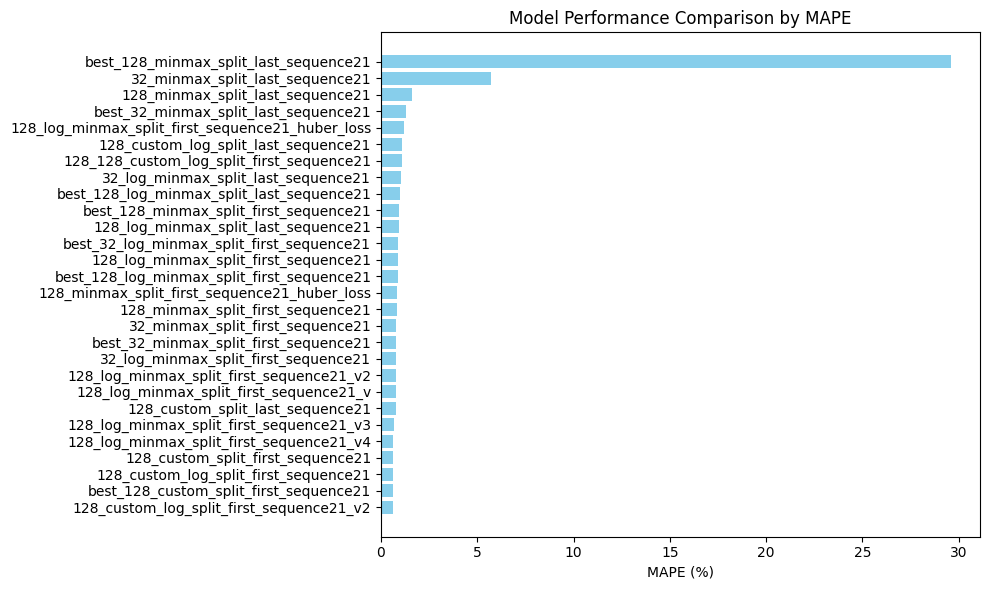

In [102]:
results = evaluate_all_models(CHECKPOINTS_PATH, test_datasets)